# Proyecto Machine Learning: Predicción de la salud fetal

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

RANDOM_STATE = 22

In [2]:
df = pd.read_csv('data/fetal_health.csv')

In [3]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
# Comprobamos que no hay datos ausentes en el dataset

if df.isnull().any().any():
    print("Hay celdas vacias en el dataset")
else:
    print("NO hay celdas vacias en el dataset")

NO hay celdas vacias en el dataset


## Explicación del problema

El problema que vamos a abordar trata sobre la salud fetal. En concreto, vamos a intentar predecir el estado de salud de un feto en base a una serie de variables con el fin de prevenir mortalidad fetal y maternal.

Para ello, contamos con un dataset de 2126 muestras, cada una de ellas con 22 variables. Estas muestras fueron obtenidas mediante cardiotoconografías (CTG), una técnica que se utiliza para monitorizar la frecuencia cardíaca fetal y las contracciones uterinas durante el embarazo. Posteriormente, fueron clasificadas por tres expertos en base a su estado de salud en tres categorías: normal, sospechoso y patológico.

Con estos datos, nuestro objetivo es predecir el estado de salud de un feto en base a las variables que se han obtenido mediante la CTG. Para ello, vamos a utilizar diferentes algoritmos de clasificación y vamos a comparar los resultados obtenidos con cada uno de ellos.

Es importante mencionar que, dada la naturaleza del problema, es más importante que el modelo sea capaz de detectar correctamente los casos patológicos, ya que son los que más riesgo de mortalidad tienen. Por tanto, vamos a darle más importancia a la métrica de recall de la clase `pathological` que a la de precisión. Esto es porque un recall mayor nos indicará que el modelo es capaz de detectar correctamente más casos patológicos, mientras que una mayor precisión indica que, ante un caso predecido como patológico, es más probable que sea realmente patológico.

## Visualización de los datos

En primer lugar, vamos a ver la distribución de los datos en cada una de las variables. Con esto, podremos ver la variabilidad de los datos y sus rangos, para así poder decidir si es necesario normalizarlos o no. 

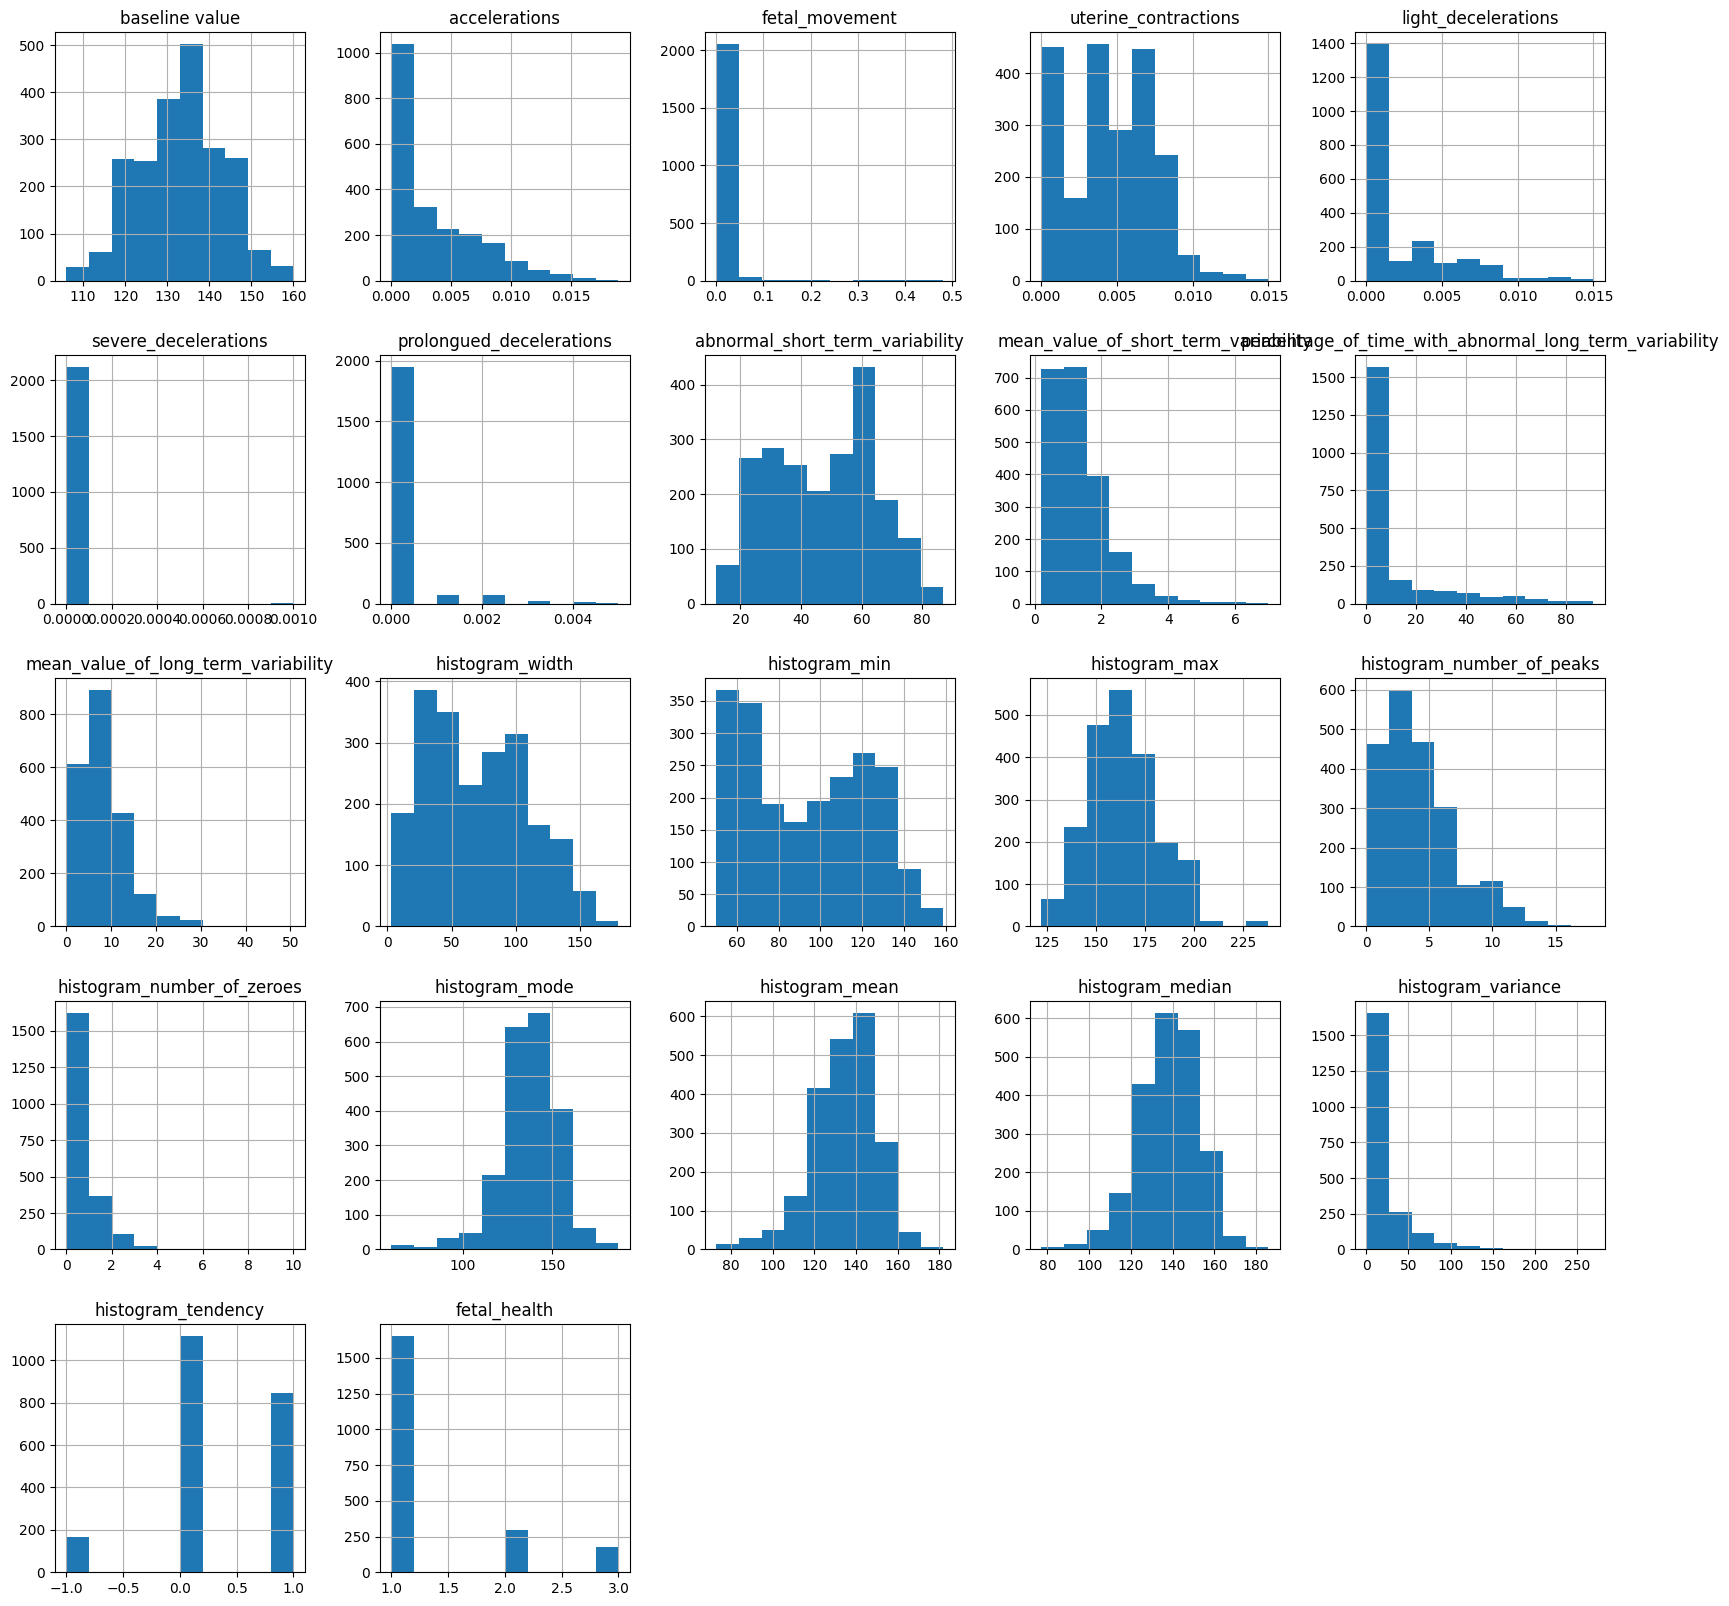

In [5]:
hist_plot = df.hist(figsize = (20,20))

Vemos que sí que va a ser necesario normalizarlos, ya que las variables tienen rangos muy diferentes. Si nos fijamos por ejemplo en las dos primeras variables (`baseline value` y `accelerations`), vemos que la primera tiene un rango de varianza de decenas (aproximadamente de 110 a 160), mientras que la segunda tiene un rango de varianza de centésimas (aproximadamente de 0.000 a 0.015).

Por lo tanto, vamos a normalizar los datos para conseguir un mejor resultado en los algoritmos de clasificación.

In [7]:
from sklearn import preprocessing

# Quitamos la variable categorica y la variable objetivo
df_aux = df.copy().drop(columns=['histogram_tendency', 'fetal_health'])

# Estandarizar datos
x = df_aux.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=df_aux.columns)

# One hot encoding sobre la variable categorica
one_hot = pd.get_dummies(df['histogram_tendency'], columns=['histogram_tendency_neg', 'histogram_tendency_0', 'histogram_tendency_pos'])
one_hot = one_hot.rename(columns={-1.0: 'histogram_tendency_neg', 
                                  0.0: 'histogram_tendency_0', 
                                  1.0: 'histogram_tendency_pos'})

# Juntar datasets
df_scaled = df_scaled.join(one_hot)
df_scaled['fetal_health'] = df['fetal_health']

In [8]:
df_scaled

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency_neg,histogram_tendency_0,histogram_tendency_pos,fetal_health
0,-1.352220,-0.822388,-0.203210,-1.482465,-0.638438,-0.057476,-0.268754,1.513190,-0.943095,1.802542,...,-0.701397,-0.458444,-1.065614,0.153270,-1.181642,1.870569,0,0,1,2.0
1,-0.132526,0.730133,-0.203210,0.554627,0.375243,-0.057476,-0.268754,-1.744751,0.868841,-0.535361,...,0.655137,0.958201,0.216638,0.089126,0.132038,-0.234998,0,1,0,1.0
2,-0.030884,-0.046128,-0.203210,1.233657,0.375243,-0.057476,-0.268754,-1.802928,0.868841,-0.535361,...,0.316003,0.958201,0.216638,0.024982,-0.006244,-0.200481,0,1,0,1.0
3,0.070757,-0.046128,-0.203210,1.233657,0.375243,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,...,2.350804,-0.458444,-0.027600,-0.039162,-0.075385,-0.200481,0,0,1,1.0
4,-0.132526,0.988886,-0.203210,1.233657,-0.638438,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,...,1.672537,-0.458444,-0.027600,0.089126,-0.006244,-0.269516,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,0.680604,-0.822388,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.862255,-1.282833,0.823885,...,-0.023130,-0.458444,0.949354,0.987141,0.961731,-0.580173,0,1,0,2.0
2122,0.680604,-0.563635,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.804078,-1.056341,0.660775,...,0.655137,-0.458444,0.888294,0.858853,0.892590,-0.545656,0,0,1,2.0
2123,0.680604,-0.563635,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.862255,-1.056341,0.552035,...,0.316003,-0.458444,0.949354,0.858853,0.961731,-0.511138,0,0,1,2.0
2124,0.680604,-0.563635,-0.203210,0.554627,-0.638438,-0.057476,-0.268754,1.804078,-1.056341,0.932624,...,0.655137,-0.458444,0.888294,0.794709,0.892590,-0.511138,0,0,1,2.0


Como tenemos un problema de clasificación en tres clases, vamos a estuidar el desbalanceo de los datos.

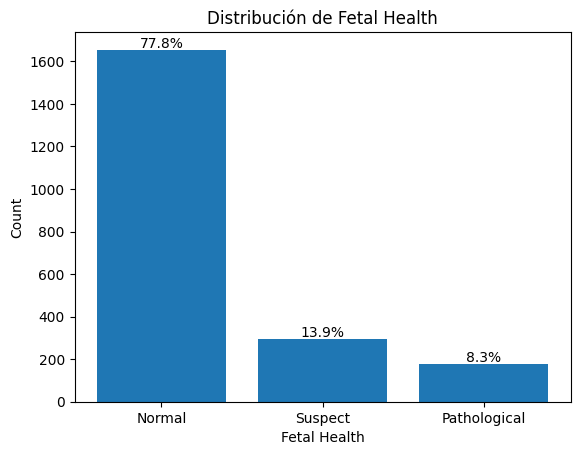

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Contamos el numero de valores de cada clase
class_counts = df['fetal_health'].value_counts()

# Calculamos el porcentaje de cada clase
class_percentages = (class_counts / class_counts.sum()) * 100

# Dibujamos el grafico de barras
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts.values)

# Añadimos las etiquetas de porcentaje
for i, count in enumerate(class_counts):
    ax.text(i+1, count + 10, f'{class_percentages[i+1]:.1f}%', ha='center')

# Etiquetas del grafico
ax.set_xlabel('Fetal Health')
ax.set_ylabel('Count')
ax.set_title('Distribución de Fetal Health')

ax.set_xticks(class_counts.index)
ax.set_xticklabels(['Normal', 'Suspect', 'Pathological'])  # Modify labels as per your target classes

# Mostramos el grafico
plt.show()


Vemos que hay un desbalanceo bastante pronunciado de los datos, ya que la clase mayoritaria (`Normal`) tiene un 77.8% de los datos, mientras que la clase minoritaria (`Pathologic`) tiene un 8.3% y la clase intermedia (`Suspect`) tiene un 13.9%. Por ello, será fundamental que nuestros algoritmos de clasificación estén evaluados con métricas que tengan en cuenta el desbalanceo de los datos, como por ejemplo la precisión, el recall o el F1-score.

Además, como ya hemos mencionado antes, será importante fijarnos especialmente en el recall the la clase `Pathologic`, ya que es la que más riesgo de mortalidad tiene.

Por último, vamos a estudiar la correlación de cada variable con la etiqueta. Para ello, vamos a utilizar el coeficiente de correlación de Pearson, que nos indicará la correlación lineal entre dos variables. Este coeficiente puede tomar valores entre -1 y 1, donde 1 indica una correlación positiva perfecta, -1 indica una correlación negativa perfecta y 0 indica que no hay correlación.

<AxesSubplot: >

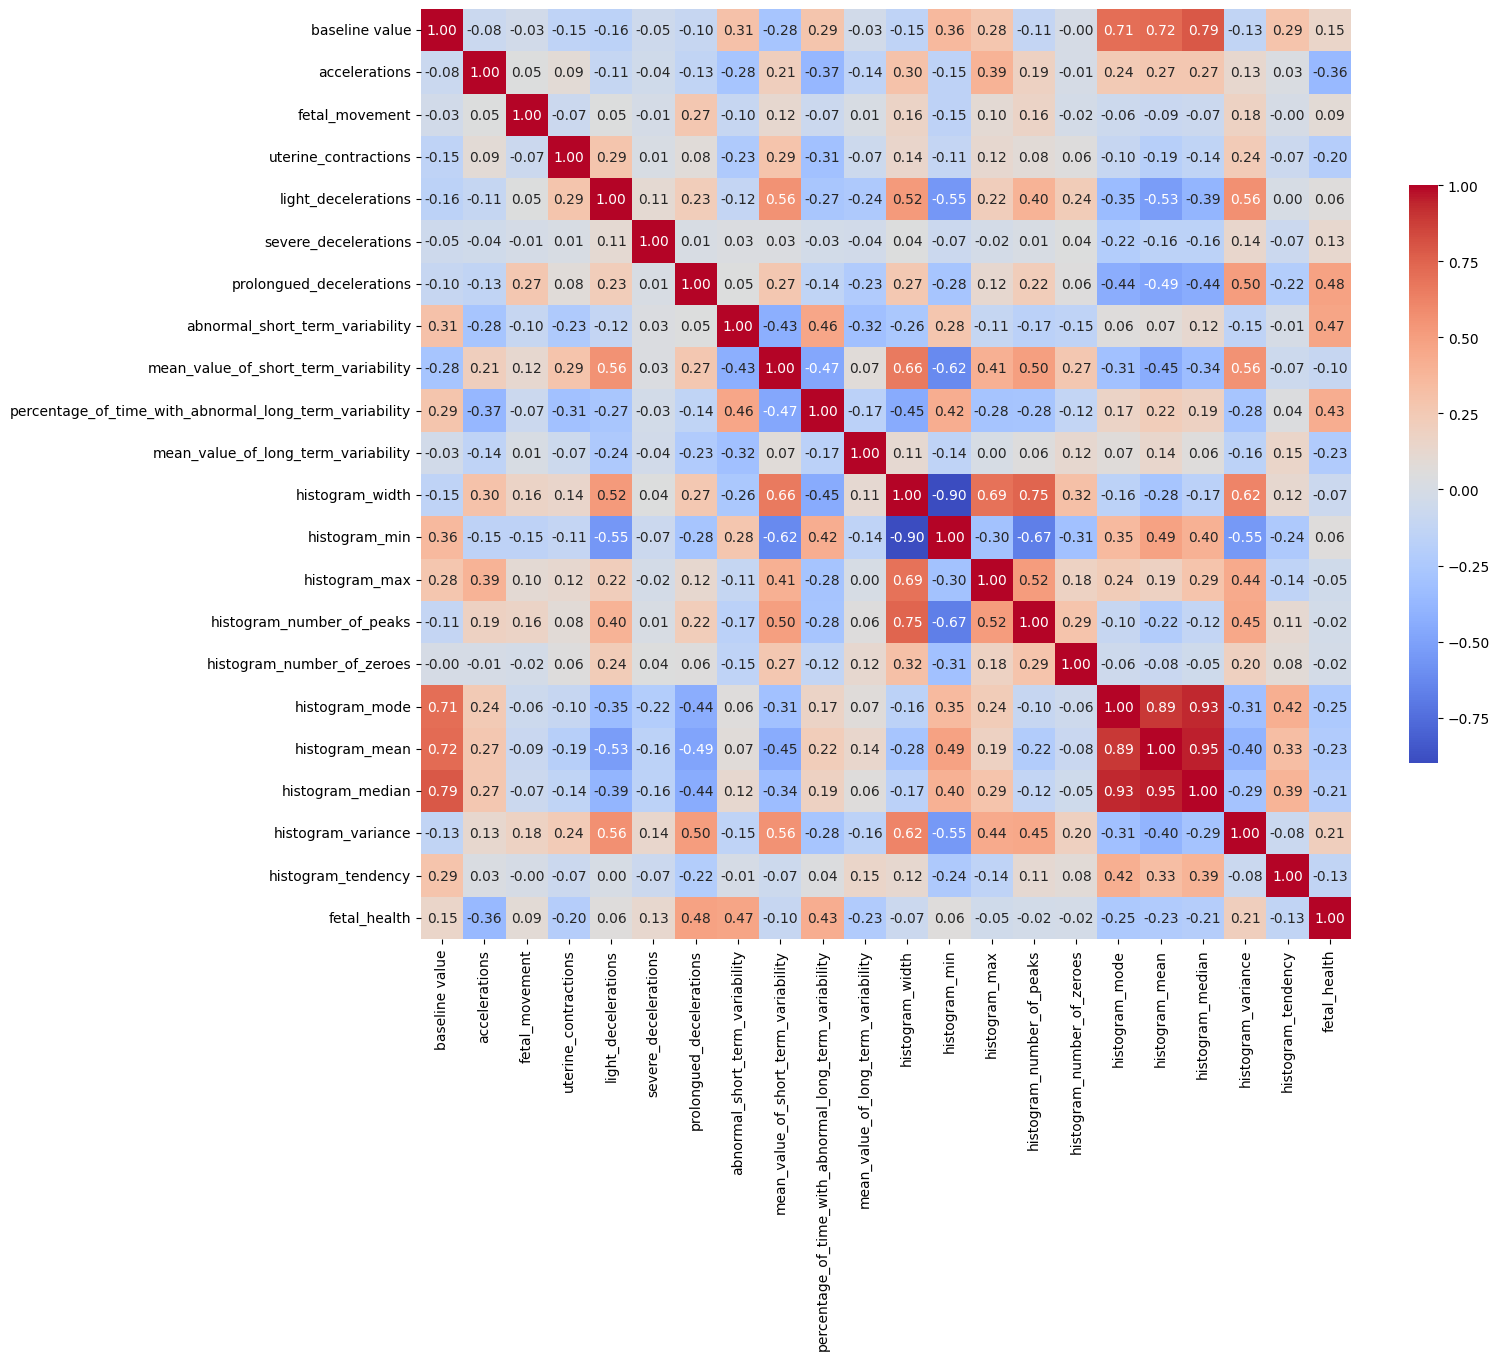

In [11]:
corrmat = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrmat, vmax=1, square=True, annot=True, fmt='.2f', cmap="coolwarm", cbar_kws={"shrink": .5})

Podemos ver que las variables más correlacionadas positivamente con la etiqueta son `prolongued_decelerations` y `abnormal_short_term_variability`, con una correlación de 0.48 y 0.47 respectivamente. Por otro lado, las variables más correlacionadas negativamente con la etiqueta son `accelerations`, con una correlación de -0.36, y `histogram_mode`, con una correlación de -0.25.

Ninguna de estas correlaciones es muy elevada, por lo que el uso de modelos de aprendizaje automático puede ser beneficioso para este problema, ya que vamos a poder encontrar relaciones complejas entre variables.

## División y guardado de los datos

In [9]:
# Estratificamos los datos dejando una proporcion 60 - 20 - 20
train, aux = train_test_split(df_scaled, test_size=0.4, shuffle=True, stratify=df['fetal_health'])
test, val = train_test_split(aux, test_size=0.5, shuffle=True, stratify=aux['fetal_health'])

In [10]:
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

## Algoritmos de clasificación

Los distintos algoritmos de clasificación que vamos a utilizar son los siguientes:

- Regresión logística
- Redes neuronales
- Árboles de decisión
- XGBoost

Cada uno de ellos contiene su respectivo Jupyter Notebook, en el que se explica el proceso de entrenamiento y evaluación del modelo. Para todos ellos, además se realizan visualizaciones de los resultados obtenidos para poder ser comparados.

A continuación, vamos a comparar los resultados obtenidos con cada uno de ellos a modo de resumen y conclusión.

## Comparación de los resultados

|                     |     F1     |  Accuracy  | Recall (Pathological) |   Tiempo  |
|---------------------|:----------:|:----------:|:---------------------:|:---------:|
| Regresión logística |   92.44%*  |   92.47%*  |        97.14%*        |    16s    |
|   Redes neuronales  |   90.65%   |   90.82%   |       **91.43%**      |    25s    |
|  Árbol de decisión  |   92.10%   |   92.00%   |       **91.43%**      | **0.02s** |
|       XGBoost       | **93.70%** | **93.88%** |       **91.43%**      |   0.51s   |

*Para la comparación de los resultados, es importante recalcar que las métricas de la regresión logística no son directamente comparables con los demás modelos porque con la regresión logística estamos tratando de resolver un problema distinto, que es clasificar entre "Normal" y "Sospechoso+Patológico" (perteneciente a una de las dos). Es decir, es un problema de clasificación binaria juntando dos clases.

De entre las 17 predicciones incorrectas de la clase "Normal", tan solo 1 pertenece a "Patológico" dentro de la clase "Sospechoso+Patológico". Esto implica el alto recall que vemos en la clase "Patológico" de la regresión logística, ya que es capaz de detectar correctamente la mayoría de los casos patológicos. Sin embargo, el recall entre las clases "Normal" y "Sospechoso+Patológico"  es del 82%, lo que implica que la mayoría de confusiones vienen entre las clases "Normal" y "Sospechoso". Esto es un resultado positivo, ya que es preferible que el modelo se equivoque en clasificar un caso como "Sospechoso" a que lo clasifique como "Patológico".

Por otro lado, vemos que el modelo de redes neuronales tiene una F1 de 90.65%, que es la mínima de entre todos los modelos estudiados. Además, es el modelo más lento de entrenar, y es un modelo de caja negra, por lo que no es interpretable ni explicable. Sin embargo, es importante tener en cuenta que solo contamos con 2126 datos, que es un número bastante pequeño para entrenar redes neuronales. Por ello, creemos que es el modelo que mejor escalaría con más datos de entrenamiento.

El modelo de árbol de decisión es el más rápido de entrenar, y tiene un F1 de 92.10%. Además, es un modelo interpretable, por lo que podemos ver las reglas de decisión que ha aprendido. Este ligero empeoramiento en el F1 puede ser asumible, teniendo en cuenta que el modelo es mucho más rápido de entrenar y que es interpretable. Esto es especialmente importante para una puesta en producción, ya que si el modelo es interpretable, podemos explicar a los médicos las reglas de decisión que ha aprendido, y así pueden entender por qué el modelo ha tomado una decisión u otra.

Por último, el modelo de XGBoost tiene un F1 de 93.70%, que es muy similar al de redes neuronales. Además, es un modelo interpretable, por lo que podríamos explicar sus resultados. Como punto negativo, XGBoost es bastante más lento de entrenar que el árbol de decisión.

En cuanto al recall de la clase "Patológico", vemos que todos los modelos comparables tienen un recall del 91.43%. Viendo sus matrices de confusión, vemos que en todos ellos fallan 3 predicciones de la clase "Patológico", que se predicen como "Normal". A priori, esto parece un problema, ya que es preferible que el modelo se equivoque en clasificar un caso como "Sospechoso" a que lo clasifique como "Normal" para perjudicar lo mínimo posible en la salud. Sin embargo, viendo que los tres modelos fallan en las mismas predicciones, concluimos que se trata de outliers, y que son datos difíciles de clasificar.

Por lo tanto, el modelo a elegir para este problema depende de las necesidades de la aplicación. Si se necesita un modelo rápido de entrenar y que sea interpretable, el modelo de árbol de decisión es el más adecuado. Si se necesita un modelo razonablemente rápido de entrenar y que sea muy preciso, el modelo de XGBoost es el más adecuado. Por último, si se tuvieran más datos, y si se necesitara un modelo muy preciso y no importase que fuera lento de entrenar y una caja negra, quizá el modelo de redes neuronales sería el más adecuado por su escalabilidad.